In [1]:
# importazione librerie necessarie

import tensorflow as tf
tf.random.set_seed(42)

import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(42)

from tensorflow.keras import utils as ku
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2021-10-15 14:22:33.482188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


2021-10-15 14:22:34.541983: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-15 14:22:34.630582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 14:22:34.631538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-15 14:22:34.631593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 14:22:34.632522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:41:

In [2]:
filters = '…,.!?§«»ª™#$%&()*‘’`"”"\'+-–/:;<=>@[\\]^_{|}~\t\n\x0c'

text = open("data/guida_galattica_per_gli_autostoppisti.txt", encoding='utf-8').read()
text2 = open("data/ristorante_al_termine_dell_universo.txt", encoding='utf-8').read()
text3 = open("data/la_vita_l_universo_e_tutto_quanto.txt", encoding='utf-8').read()
text4 = open("data/addio_e_grazie_per_tutto_il_pesce.txt", encoding='utf-8').read()
text5 = open("data/praticamente_innocuo.txt", encoding='utf-8').read()

text += ' ' + text2 + ' ' + text3 + ' ' + text4 + ' ' + text5

text = text.upper()

# rimozione dei caratteri speciali
# n.b. non rimuoviamo le cifre quindi
# i numeri presenti nel testo saranno
# considerati ognuno come una "parola"
# fatta di lettere nel testo
for c in filters:
    text = text.replace(c, ' ')

text = text.replace('  ', ' ')

# visualizzazione dell'inizio del
# testo delle cinque parti della trilogia :)
print(text[:500])

LONTANO NEI DIMENTICATI SPAZI NON SEGNATI NELLE CARTE GEOGRAFICHE DELL ESTREMO LIMITE DELLA SPIRALE OVEST DELLA GALASSIA C È UN PICCOLO E INSIGNIFICANTE SOLE GIALLO A ORBITARE INTORNO A ESSO ALLA DISTANZA DI CENTOQUARANTANOVE MILIONI DI CHILOMETRI C È UN PICCOLO TRASCURABILISSIMO PIANETA AZZURRO VERDE LE CUI FORME DI VITA DISCENDENTI DALLE SCIMMIE SONO COSÌ INCREDIBILMENTE PRIMITIVE CHE CREDONO ANCORA CHE GLI OROLOGI DA POLSO DIGITALI SIANO UN OTTIMA INVENZIONE QUESTO PIANETA HA O MEGLIO AVEVA U


In [3]:
text = text.split(' ')
print(len(text), 'numero totale di parole nei testi')
print(len(set(text)), 'parole uniche nei testi')

281850 numero totale di parole nei testi
22919 parole uniche nei testi


In [4]:
sentence_len = 64 + 1  # 64 x_train + 1 y_train
step = 2

texts = []

for i in range(0, len(text) - sentence_len, step):
    texts.append(text[i:i + sentence_len])

print(len(texts), 'esempi')
print('')
for i in range(15):
    print(texts[i])

140893 esempi

['LONTANO', 'NEI', 'DIMENTICATI', 'SPAZI', 'NON', 'SEGNATI', 'NELLE', 'CARTE', 'GEOGRAFICHE', 'DELL', 'ESTREMO', 'LIMITE', 'DELLA', 'SPIRALE', 'OVEST', 'DELLA', 'GALASSIA', 'C', 'È', 'UN', 'PICCOLO', 'E', 'INSIGNIFICANTE', 'SOLE', 'GIALLO', 'A', 'ORBITARE', 'INTORNO', 'A', 'ESSO', 'ALLA', 'DISTANZA', 'DI', 'CENTOQUARANTANOVE', 'MILIONI', 'DI', 'CHILOMETRI', 'C', 'È', 'UN', 'PICCOLO', 'TRASCURABILISSIMO', 'PIANETA', 'AZZURRO', 'VERDE', 'LE', 'CUI', 'FORME', 'DI', 'VITA', 'DISCENDENTI', 'DALLE', 'SCIMMIE', 'SONO', 'COSÌ', 'INCREDIBILMENTE', 'PRIMITIVE', 'CHE', 'CREDONO', 'ANCORA', 'CHE', 'GLI', 'OROLOGI', 'DA', 'POLSO']
['DIMENTICATI', 'SPAZI', 'NON', 'SEGNATI', 'NELLE', 'CARTE', 'GEOGRAFICHE', 'DELL', 'ESTREMO', 'LIMITE', 'DELLA', 'SPIRALE', 'OVEST', 'DELLA', 'GALASSIA', 'C', 'È', 'UN', 'PICCOLO', 'E', 'INSIGNIFICANTE', 'SOLE', 'GIALLO', 'A', 'ORBITARE', 'INTORNO', 'A', 'ESSO', 'ALLA', 'DISTANZA', 'DI', 'CENTOQUARANTANOVE', 'MILIONI', 'DI', 'CHILOMETRI', 'C', 'È', 'UN', '

In [5]:
max_words = 10000  # le 10000 parole più frequenti nei testi
                   # pari a poco meno del 50% dell'intero dizionario

tokenizer = Tokenizer(
    num_words=max_words,
    oov_token='___',  # token per le circa 13000 parole meno
                      # frequenti nei testi
)
tokenizer.fit_on_texts(texts)

In [6]:
input_sequences = tokenizer.texts_to_sequences(texts)

# avendo utilizzato l'out-of-vocabulary token, non c'è
# necessità di effettuare un padding delle sequenze
# alternativamente si dovrebbe eseguire:
#
# input_sequences = pad_sequences(
#     input_sequences,
#     padding="post"
# )

In [7]:
examples = [x[:-1] for x in input_sequences]
labels = [x[-1] for x in input_sequences]

In [8]:
labels = ku.to_categorical(labels, num_classes=max_words)

In [9]:
examples = np.asarray(examples)
labels  = np.asarray(labels)

print('Examples :', examples.shape)
print('Labels   :', labels.shape)

Examples : (140893, 64)
Labels   : (140893, 10000)


In [10]:
K.clear_session()

def get_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=len(examples[0])))
    model.add(LSTM(2048, return_sequences=True))
    model.add(LSTM(1024, return_sequences=True))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(1024, return_sequences=True))
    model.add(LSTM(2048))
    model.add(Dense(max_words, activation='softmax', dtype='float32'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.003, epsilon=1e-9), metrics='accuracy')
    return model

model = get_model()
model.summary()

2021-10-15 14:22:42.983794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-15 14:22:43.151237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 14:22:43.152277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-15 14:22:43.152329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but t

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64, 2048)          17833984  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 1024)          12587008  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 512)           3147776   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64, 1024)          6295552   
_________________________________________________________________
lstm_4 (LSTM)                (None, 2048)              25174016  
_________________________________________________________________
dense (Dense)                (None, 10000)             2

In [11]:
# la callback lavora sul loss e non sull'accuracy, come in altri casi,
# perché l'accuracy ci dà "1" quando l'output con probabilità più alta
# coincide con il valore vero, indipendentemente da quanto valgono gli
# altri output. Il loss tiene in considerazione tutti gli output e
# quando stagna questo indicatore potrebbe aver senso diminuire il
# learning rate per far proseguire l'addestramento (considerando
# l'accuracy, il learning rate diminuirebbe nel momento in cui, di
# epoca in epoca, il modello fornisse lo stesso numero di output
# uguali ai valori desiderati, mentre invece potrebbe comunque
# stare ancora migliorando le sue performance, considerando appunto
# il loss)
history = model.fit(
    examples,
    labels,
    epochs=1000,
    batch_size=512,
    callbacks=[
        ReduceLROnPlateau(
            patience=13,
            factor=0.75,
            monitor='loss',
            mode='min',
            min_lr=1e-5,
            verbose=1
        ),
        EarlyStopping(
            patience=42,
            monitor='loss',
            mode='min',
            restore_best_weights=True,
            verbose=1
        )
    ],
    verbose=2
)

2021-10-15 14:23:03.022865: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-15 14:23:03.040108: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2994670000 Hz


Epoch 1/1000


2021-10-15 14:23:07.000703: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-15 14:23:07.573193: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-10-15 14:23:07.876856: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-15 14:23:08.392438: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-10-15 14:23:08.392507: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


276/276 - 72s - loss: 7.0672 - accuracy: 0.0444
Epoch 2/1000
276/276 - 68s - loss: 7.0006 - accuracy: 0.0436
Epoch 3/1000
276/276 - 69s - loss: 6.9259 - accuracy: 0.0444
Epoch 4/1000
276/276 - 69s - loss: 6.9208 - accuracy: 0.0446
Epoch 5/1000
276/276 - 69s - loss: 6.9164 - accuracy: 0.0439
Epoch 6/1000
276/276 - 69s - loss: 6.9136 - accuracy: 0.0447
Epoch 7/1000
276/276 - 69s - loss: 6.9129 - accuracy: 0.0441
Epoch 8/1000
276/276 - 69s - loss: 6.9118 - accuracy: 0.0436
Epoch 9/1000
276/276 - 69s - loss: 6.9138 - accuracy: 0.0448
Epoch 10/1000
276/276 - 69s - loss: 6.9110 - accuracy: 0.0446
Epoch 11/1000
276/276 - 69s - loss: 6.9108 - accuracy: 0.0450
Epoch 12/1000
276/276 - 69s - loss: 6.9130 - accuracy: 0.0441
Epoch 13/1000
276/276 - 69s - loss: 6.9116 - accuracy: 0.0448
Epoch 14/1000
276/276 - 69s - loss: 6.9099 - accuracy: 0.0449
Epoch 15/1000
276/276 - 68s - loss: 6.9108 - accuracy: 0.0439
Epoch 16/1000
276/276 - 68s - loss: 6.9102 - accuracy: 0.0449
Epoch 17/1000
276/276 - 68s - 

In [12]:
# backup addestramento

model.save_weights('weights/words_generation')
pickle.dump(history.history, open('weights/history.bck', 'wb'))

In [13]:
# recupero pesi e log di addestramento
model.load_weights('weights/words_generation')
history = pickle.load(open('weights/history.bck', 'rb'))

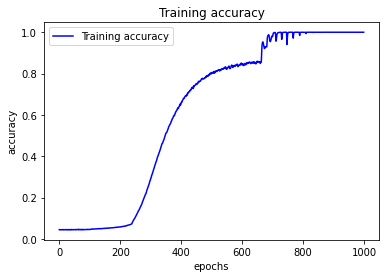

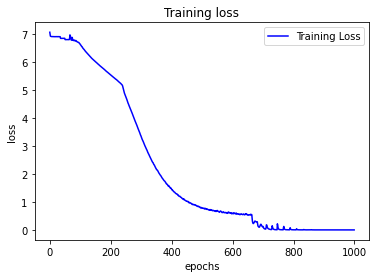

In [14]:
# visualizzazione andamento addestramento

acc = history['accuracy']
loss = history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

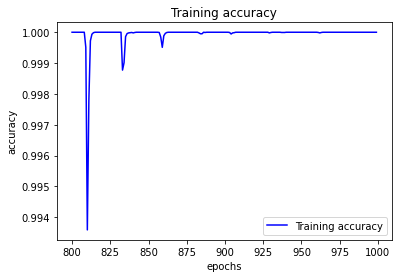

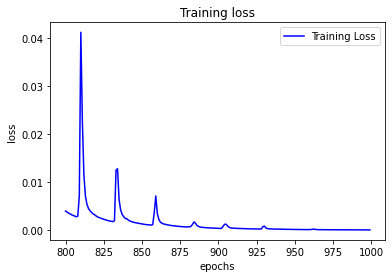

In [17]:
# visualizzazione andamento della
# parte finale dell'addestramento

plt.plot(epochs[800:], acc[800:], 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs[800:], loss[800:], 'b', label='Training Loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
K.clear_session()

model = get_model()
model.load_weights('weights/words_generation')

# generazione nuovo testo

seed_text = texts[42000][:-1]
print('Frase iniziale:', seed_text)

next_words = 100

reverse_word_map = (dict(map(reversed, tokenizer.word_index.items())))

for i in range(next_words):
    token_list = tokenizer.texts_to_sequences(seed_text)
    for i, t in enumerate(token_list):
        if len(token_list[i]) == 0:
            token_list[i] = [1]
    token_list = np.asarray(token_list)
    token_list = np.reshape(np.asarray(np.squeeze(token_list)), (1, len(examples[0]), 1))
    pred_token = model.predict(token_list, verbose=0)
    pred_token = (pred_token[0]).argsort(axis=-1)[-5:]
    # variazione casuale della selezione del migliore output
    # permette di avere un output più "creativo" e meno
    # simile al testo di addestramento
    rnd = np.random.random()
    if rnd > 0.975:
        pred_token = pred_token[4]
    elif rnd > 0.95:
        pred_token = pred_token[3]
    elif rnd > 0.90:
        pred_token = pred_token[2]
    elif rnd > 0.85:
        pred_token = pred_token[1]
    else:
        pred_token = pred_token[0]
    word_predicted = tokenizer.sequences_to_texts([[pred_token]])[0]
    print(word_predicted + ' ', end='')
    seed_text = np.append(seed_text, pred_token)
    seed_text = seed_text[1:]

Frase iniziale: ['TEMPO', 'SI', 'ACCOSTÒ', 'ALLA', 'NAVE', 'LA', 'TOCCÒ', 'E', 'SUBITO', 'SI', 'APRÌ', 'UN', 'PORTELLO', 'FORD', 'E', 'ZAPHOD', 'LO', 'FISSARONO', 'SBALORDITI', 'DI', 'NIENTE', 'DISSE', 'MARVIN', 'AH', 'GIÀ', 'VI', 'FACCIO', 'NOTARE', 'CHE', 'NON', 'MI', 'AVETE', 'NEANCHE', 'DETTO', 'GRAZIE', 'SI', 'ALLONTANÒ', 'DI', 'NUOVO', 'STRASCICANDO', 'I', 'PIEDI', 'ARTHUR', 'E', 'TRILLIAN', 'SI', 'AVVICINARONO', 'ALL', 'ASTRONAVE', '', 'COSA', 'STA', 'SUCCEDENDO', '', 'DISSE', 'ARTHUR', '', 'GUARDA', 'QUA', '', 'DISSE', 'FORD', '', 'GUARDA']
solo secondo lo da nel davanti il ___ la simile un girò sopra lo ford casualità tanto forte e me quando arthur tanto poco ford lì all ostilità in siano ___ per effetti i che orbita o così fare avrebbero sai qui che macchina pareva male dal brillava dall immensità aperto ogni tranne ___ e portarci confini più stare distanza pensò secondo mani la immensità direzione mezzo tal siepe ___ se è stare direzione cose è due improbabilità vita thrashb